Build and Train a VGG 16 like model to classify cats and dogs. 
Here's the [VGG16](https://arxiv.org/abs/1409.1556) paper. 
A layer by layer build up is give [here](https://github.com/keras-team/keras-applications/blob/master/keras_applications/vgg16.py). <br>

Due to time limitations the network is little simpler than vgg16. Total number of training images are 2800, with 1400 each for cats and dogs. 
Validation set consists of 600 images. The model reaches $\sim 90\%$ accuracy after 100 epochs. Takes around 1 hour to train the model.     

In [0]:
import tensorflow as tf
import numpy as np
import os, time
import matplotlib.pyplot as plt

In [0]:
keras = tf.keras

### Mount Google Drive 

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


### Build the Model using Sequential 

In [0]:
model = keras.models.Sequential([
                                 keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=(160, 160, 3) ),
                                 keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same', name='block0_conv2'), 
                                 keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block0_pool1'), #end of block 0
                                 keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', name='block1_conv1'),
                                 keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', name='block1_conv2'), 
                                 keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool1'), 
                                 keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='block2_conv1'), 
                                 keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='block2_conv2'), 
                                 keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool1'), # end of block2
                                 keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='block3_conv1'), 
                                #  keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='block3_conv2'), 
                                #  keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='block3_conv3'), 
                                 keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool'), # end of block3, we use only 3 blocks
                                 keras.layers.Flatten(), 
                                 keras.layers.Dense(512, activation='relu'), 
                                 keras.layers.Dropout(0.4, name='Dropout_1'), 
                                 keras.layers.Dense(1, activation='sigmoid')
                                 ])

In [0]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 160, 160, 16)      448       
_________________________________________________________________
block0_conv2 (Conv2D)        (None, 160, 160, 16)      2320      
_________________________________________________________________
block0_pool1 (MaxPooling2D)  (None, 80, 80, 16)        0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 80, 80, 32)        4640      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 80, 80, 32)        9248      
_________________________________________________________________
block1_pool1 (MaxPooling2D)  (None, 40, 40, 32)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 40, 40, 64)        1

### Data Pre-Processing  
Files are directly processed from Google Drive folders

In [6]:
cat_train_dir = os.path.join('/content/gdrive/My Drive/Colab Notebooks/cats_and_dogs_filtered/train/cats')
dog_train_dir = os.path.join('/content/gdrive/My Drive/Colab Notebooks/cats_and_dogs_filtered/train/dogs')

cat_test_dir = os.path.join('/content/gdrive/My Drive/Colab Notebooks/cats_and_dogs_filtered/test/cats')
dog_test_dir = os.path.join('/content/gdrive/My Drive/Colab Notebooks/cats_and_dogs_filtered/test/dogs')


cat_train_images = os.listdir(cat_train_dir)
dog_train_images = os.listdir(dog_train_dir)


print ("number of cat training images: ", len(os.listdir(cat_train_dir)))
print ("number of dog training images: ", len(os.listdir(dog_train_dir)))

print ("number of cat test images: ", len(os.listdir(cat_test_dir)))
print ("number of dog test images: ", len(os.listdir(dog_test_dir)))




from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1/255.,  
                                  horizontal_flip=True,
                                  zoom_range=0.0, 
                                  height_shift_range=0.2,
                                  width_shift_range=0.1)


test_datagen = ImageDataGenerator(rescale=1/255.,)


train_datagenerator = train_datagen.flow_from_directory('/content/gdrive/My Drive/Colab Notebooks/cats_and_dogs_filtered/train', 
                                                       batch_size=28, 
                                                       class_mode='binary', 
                                                       target_size=(160, 160))

test_datagenerator = test_datagen.flow_from_directory('/content/gdrive/My Drive/Colab Notebooks/cats_and_dogs_filtered/test', 
                                                     batch_size=15, 
                                                     class_mode='binary', 
                                                     target_size=(160, 160))

number of cat training images:  1400
number of dog training images:  1401
number of cat test images:  301
number of dog test images:  300
Found 2801 images belonging to 2 classes.
Found 601 images belonging to 2 classes.


### Compile and Fit the Model

In [7]:



model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), 
             loss='binary_crossentropy', 
             metrics=['acc'])



history = model.fit_generator(train_datagenerator, 
                              steps_per_epoch=100, 
                              epochs=100, 
                              validation_data=test_datagenerator, 
                              validation_steps=40, 
                              verbose=2)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/100
Epoch 1/100
100/100 - 805s - loss: 0.6928 - acc: 0.5200 - val_loss: 0.6928 - val_acc: 0.5017
Epoch 2/100
Epoch 1/100
100/100 - 32s - loss: 0.6903 - acc: 0.5380 - val_loss: 0.6785 - val_acc: 0.6050
Epoch 3/100
Epoch 1/100
100/100 - 32s - loss: 0.6613 - acc: 0.6076 - val_loss: 0.6241 - val_acc: 0.6900
Epoch 4/100
Epoch 1/100
100/100 - 31s - loss: 0.6254 - acc: 0.6592 - val_loss: 0.5966 - val_acc: 0.6700
Epoch 5/100
Epoch 1/100
100/100 - 31s - loss: 0.5978 - acc: 0.6805 - val_loss: 0.5362 - val_acc: 0.7000
Epoch 6/100
Epoch 1/100
100/100 - 31s - loss: 0.5762 - acc: 0.7065 - val_loss: 0.5646 - val_acc: 0.6883
Epoch 7/100
Epoch 1/100
100/100 - 31s - loss: 0.5510 - acc: 0.7212 - val_loss: 0.5289 - val_acc: 0.7283
Epoch 8/100
Epoch 1/100
100/100 - 31s - loss: 0.5649 - acc: 0.7129 - val_loss: 0.4981 - val_acc: 0.7517
Epoch 9/100
Epoch 1/100
100/100 - 32s - loss: 0.5392 - acc: 0.7270 - val_

 ### Plot the Accuracy and Loss

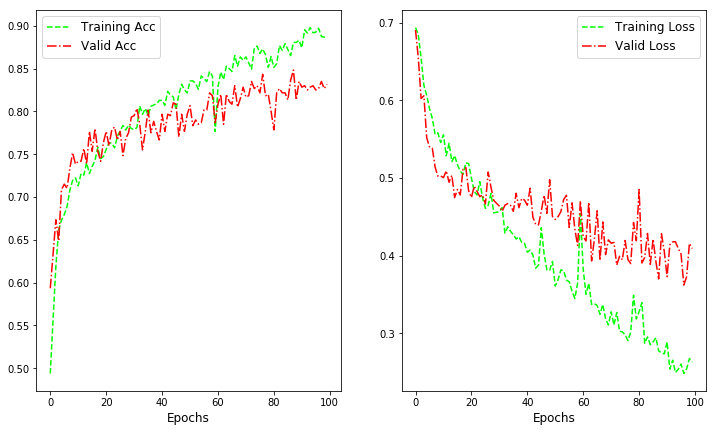

In [0]:
# train_acc = history.history['acc']
# valid_acc = history.history['val_acc']

# train_loss = history.history['loss']
# valid_loss = history.history['val_loss']

# epochs = range(len(train_acc))


# fig = plt.figure(figsize=(12, 7))
# plt.subplot(1, 2, 1)
# plt.plot(epochs, train_acc, linestyle='--', color='lime', label='Training Acc')
# plt.plot(epochs, valid_acc, linestyle='-.', color='red', label='Valid Acc')
# plt.xlabel('Epochs', fontsize=12)
# plt.legend(fontsize=12)
# plt.subplot(1, 2, 2)
# plt.plot(epochs, train_loss, linestyle='--', color='lime', label='Training Loss')
# plt.plot(epochs, valid_loss, linestyle='-.', color='red', label='Valid Loss')
# plt.xlabel('Epochs', fontsize=12)
# plt.legend(fontsize=12)
# # plt.savefig('/content/gdrive/My Drive/Colab Notebooks/build_VGG16like_loss_acc.png', dpi=200)
# plt.show()

### Check the Performance of the Model on Random Images  

Checking the performance of the model on some random images downloaded from internet  

Using TensorFlow backend.


result vector:  [[0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]]
arg_result type:  <class 'numpy.ndarray'>
arg_result : [0 0 0 0 0 0 0 0 0 0 0 0]


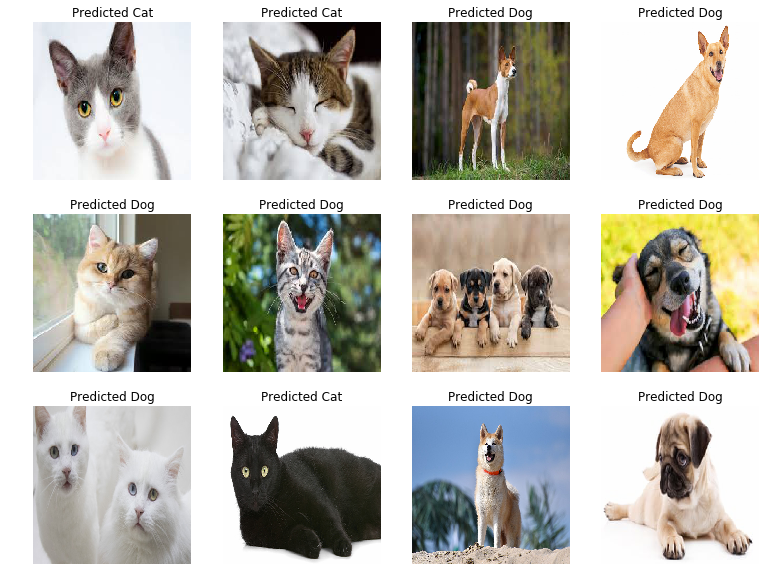

In [0]:
from keras.preprocessing import image 

rand_ims_dir = os.path.join('/content/gdrive/My Drive/Colab Notebooks/cats_and_dogs_filtered/fromnet')

random_images = os.listdir(rand_ims_dir)

IMG_SIZE = 160

batch_holder = np.zeros((12, IMG_SIZE, IMG_SIZE, 3)) # folder contains 6 images 
for i,img in enumerate(random_images):
    img= image.load_img(os.path.join(rand_ims_dir,img), target_size=(IMG_SIZE,IMG_SIZE))
    batch_holder[i, :] = img

result = model.predict(batch_holder)
arg_result = np.argmax(result, axis=1)
# 
print("result vector: ", result)
print ("arg_result type: ", type(arg_result))
print ("arg_result :", arg_result)
# 
fig = plt.figure(figsize=(13, 10))
 
for i,img in enumerate(batch_holder):
    fig.add_subplot(3,4, i+1)
    plt.axis("off")
    if result[i][0]>0:
        plt.title("Predicted Dog")
    else:
        plt.title("Predicted Cat")
    plt.axis("off")    
    plt.imshow(img/256.)

### Visualizing Some of the Conv Layer Outputs

layer names list: ['conv2d_1', 'block0_conv2', 'block0_pool1', 'block1_conv1', 'block1_conv2', 'block1_pool1', 'block2_conv1', 'block2_conv2', 'block2_pool1', 'block3_conv1', 'block3_pool', 'flatten_1', 'dense_2', 'Dropout_1', 'dense_3']
[1, 6, 7]
random file name:  /content/gdrive/My Drive/Colab Notebooks/cats_and_dogs_filtered/train/cats/cat.11357.jpg
shape of selected image : (160, 160, 3)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in true_divide


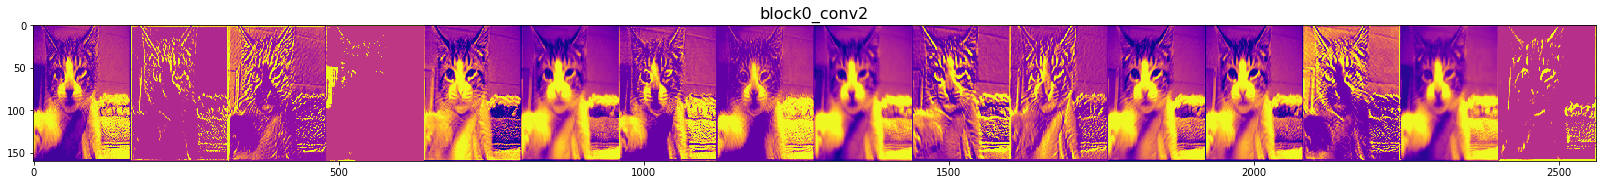

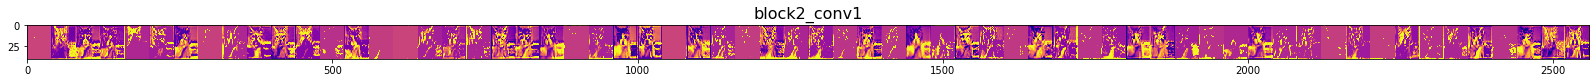

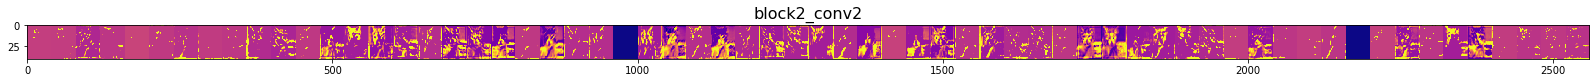

In [16]:
from keras.preprocessing.image import load_img, img_to_array
import random
layer_names_list = [layr.name for layr in model.layers]
print ("layer names list:", layer_names_list)


# selected_layers = ['block0_conv2', 'block1_conv2', 'block2_conv2', 'block3_conv1']
selected_layers = ['block0_conv2', 'block2_conv1', 'block2_conv2']

matched_indices = [i for i, item in enumerate(layer_names_list) if item in selected_layers]

print (matched_indices)


selected_layers_outputs = []

for lr in range(len(matched_indices)):
  outputs = model.layers[matched_indices[lr]].output
  selected_layers_outputs.append(outputs)


visual_model = keras.models.Model(inputs = model.input, outputs = selected_layers_outputs)

dog_files = [os.path.join(dog_train_dir, f) for f in dog_train_images]
cat_files = [os.path.join(cat_train_dir, g) for g in cat_train_images]


random_cat_dog = random.choice(dog_files + cat_files)
print ("random file name: ", random_cat_dog)

rand_img = load_img(random_cat_dog, target_size=(160, 160))
rand_img_arr = img_to_array(rand_img)

print ("shape of selected image :", rand_img_arr.shape)

x_in = np.reshape(rand_img_arr, (1, 160, 160, 3)) # batch size 1


selected_feature_maps = visual_model.predict(x_in)



for lr_name, feat_map in zip(selected_layers, selected_feature_maps):
  n_filters = feat_map.shape[-1]
  n_size = feat_map.shape[1]
  display_grid = np.zeros((n_size, n_size * n_filters))
  for i in range(n_filters):
    y = feat_map[0, :, :, i]
    y = y - y.mean()
    y = y/y.std()
    y = y*80
    y = y + 128
    y = np.clip(y, 0, 255).astype('uint8')
    display_grid[:, i * n_size : (i+1) * n_size] = y
  scale = 20./n_filters
  plt.figure(figsize=(scale * n_filters * 1.4, scale * 2))
  plt.title(lr_name, fontsize=16)
  plt.grid(False)
  plt.imshow(display_grid, aspect='auto', cmap='plasma')